In [ ]:
# install necessary packages
!pip install PyNomaly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for PyNomaly: filename=PyNomaly-0.3.3-py3-none-any.whl size=8498 sha256=c59c68a5fb154fe9a203c9169a4991210b1104156151bf8943296c62a1f04d17
  Stored in directory: /root/.cache/pip/wheels/94/d5/46/3eb798d0a1f9e0e7016171f14b4a48f68e85f23e874bb4f02b
Successfully built PyNomaly


In [ ]:
# checking for gpu
import torch
if torch.cuda.is_available():
  print(f"gpu is available")
else:
  print(f"cpu is available")

gpu is available


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset loading and pre-processing

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# dataset path
data_path = "/content/drive/MyDrive/Leukemia/hsv_aug_s"

In [ ]:
# defining transformation
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                        ])

In [ ]:
# performing transforming into our dataset
dataset = torchvision.datasets.ImageFolder(root= data_path, transform= transforms)

In [ ]:
print("Total number of samples: ", len(dataset))

Total number of samples:  20000


**generating train set and test set from the dataset**

In [ ]:
# splitting dataset and visualize
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# This will be removed when we will load load train and test set differently

num_workers = 0
batch_size = 16

# obtain training indices that will be used for validation
valid_size= 0.2 # taking 20% data as our test set
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_data))
train_idx, test_idx = indices[split:], indices[:split]

print('After splitting train data: ',len(train_idx))
print('After splitting test data: ',len(test_idx))

# define samplers for obtaining training and test batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=test_sampler, num_workers=num_workers)
# image classes
classes = ['ALL', 'HEM']

After splitting train data:  16000
After splitting test data:  4000


**visualization**

In [ ]:
%matplotlib inline

# helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

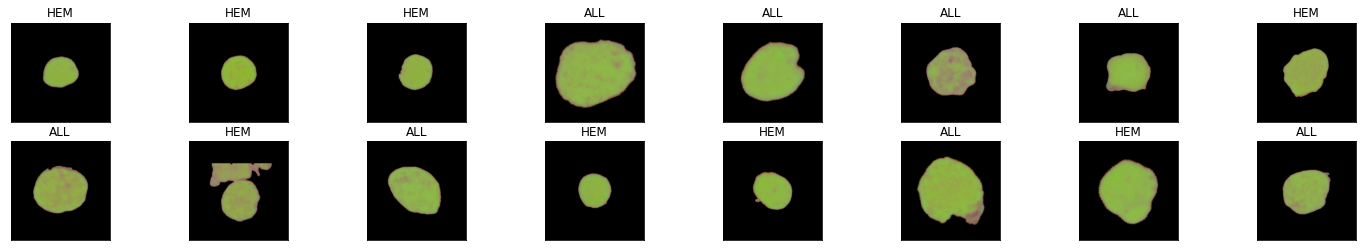

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images.numpy() # Converted Image to numpy

# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Loading pre-trained model and lable noise

**loading pre-trained model and modify**

In [ ]:
# Taking vgg19 model
from torchvision import models
vgg19 = models.vgg19(weights='IMAGENET1K_V1')  #pretrained=True

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# change the number of classes
vgg19.classifier[2] = nn.Dropout(p= 0.5, inplace= False)
vgg19.classifier[3] = nn.Linear(4096, 1024)
vgg19.classifier[5] = nn.Dropout(p= 0.25, inplace= False)
vgg19.classifier[6] = nn.Linear(1024, 2)

# freeze convolution weights
for param in vgg19.features.parameters():
    param.requires_grad = False

In [ ]:
# define hook
# hook is use to get features from expected layer
features = {}
def get_activation(name):
  def hook(model, input, output):
    if torch.cuda.is_available():
      features[name] = output.cpu().detach().numpy()
    else:
      features[name] = output.detach().numpy()
  return hook

In [ ]:
# defining modified vgg 19 as our model
model = vgg19
# moving model to GPU
if torch.cuda.is_available():
  model.cuda()
  print(f"Model moved to GPU")
else:
  print(f"Model in CPU")

Model moved to GPU


In [ ]:
# loading trained weights
model.load_state_dict(torch.load('/content/drive/MyDrive/Leukemia/label_noise/lk_final_20k_hsv_vgg19.pt'))

<All keys matched successfully>

In [ ]:
# register hooks
# we will register hooks for that layer from which we want to extract features
# and this layer information we wil get from the model's summary
model.classifier[4].register_forward_hook(get_activation('classifier[3]'))

In [ ]:
from torchvision import models
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
import torch.optim as optim
# optimizer
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9, weight_decay= 5e-4) #weight_decay= 5e-4
# optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001, betas= (0.9, 0.999), eps= 1e-8, weight_decay=0)
# loss function
criterion = nn.CrossEntropyLoss()

# implement label noise using uncertainty and pLOF

**making dataframe and detect noisy labels**

In [ ]:
# a list for column names
f_col = []
for i in range(1, 1025):
  f_col.append("f_"+ str(i))
f_col.append("loss")
f_col.append("label")
print(len(f_col))

1026


In [ ]:
# making an empty dataframe with those column names
import pandas as pd
train_loss_labels = pd.DataFrame(columns= f_col)
train_loss_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 1026 entries, f_1 to label
dtypes: object(1026)
memory usage: 0.0+ bytes


In [ ]:
train_loss_labels

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1017,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label


**forward pass and get loss and labels with corresponding features, then dump into dataframe**

In [ ]:
# now we will extract features, loss and labels from model and store into the defined dataframe
# for train samples

# we will store all imnformation in this list
sample_feat_list = []

for data, target in train_loader:
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)   # outputs len is the number of batch size --> here 16
  data_feat = features['classifier[3]']  # data features contains 16

  loss = criterion(output, target)  # producing total loss
  loss_1 = loss.cpu().detach().numpy()

  c_target = target.cpu().numpy()
  c_target = c_target.astype(int)

  # appending features, label and computed loss into list for each individual image
  for k in range(len(output)):
    # converting output features as list
    f_list = list(data_feat[k])

    # calculating loss and append to list
    loss = criterion(output[k], target[k])
    loss = loss.cpu().detach().numpy()
    f_list.append(loss)

    # getting corresponding labels
    f_list.append(c_target[k])

    # insert the list as a row in dataframe
    train_loss_labels.loc[len(train_loss_labels)] = f_list

    # clear the list
    f_list.clear()
print("completed !!")

completed !!


In [ ]:
train_loss_labels

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1017,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label
0,0.00000,0.000000,0.000000,0.124490,0.000000,0.000000,0.000000,0.017730,0.121594,0.042755,...,0.049632,0.000000,0.145983,0.364250,0.000000,0.000000,0.000000,0.0,0.3820839,0
1,0.00000,0.000000,0.000000,0.494720,0.000000,0.000000,0.832258,0.000000,0.000000,0.000000,...,0.000000,0.409121,0.065414,0.000000,0.283554,0.737353,0.000000,0.0,0.0018963703,1
2,0.00000,0.222254,0.073965,0.197426,0.067049,0.068248,0.000000,0.000000,1.008587,0.000000,...,0.000000,0.000000,0.000000,0.270376,0.000000,0.000000,0.000000,0.0,0.008116477,0
3,0.00000,0.261547,0.419098,0.000000,0.475136,0.000000,0.198079,0.016852,0.603422,0.000000,...,0.000000,0.000000,0.000000,0.372886,0.000000,0.000000,0.000000,0.0,0.014731559,0
4,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.162359,0.000000,0.000000,0.026362,...,0.000000,0.000000,0.000000,0.310478,0.000000,0.000000,0.000000,0.0,0.19120286,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014801,...,0.000000,0.000000,0.122795,0.329416,0.000000,0.000000,0.000000,0.0,0.12489656,0
15996,0.03798,0.000000,0.000000,0.000000,0.000000,0.000000,0.287219,0.003793,0.000000,0.000000,...,0.000000,0.041056,0.019139,0.000000,0.000000,0.081955,0.018327,0.0,0.063320555,1
15997,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.522346,0.126552,0.063396,0.000000,...,0.000000,0.000000,0.000000,0.057808,0.002125,0.318777,0.000000,0.0,0.36665577,1
15998,0.00000,0.000000,0.000000,0.000000,0.118977,0.000000,0.015331,0.078861,0.000000,0.000000,...,0.000000,0.000000,0.029400,0.379205,0.000000,0.000000,0.000000,0.0,0.21463934,0


In [ ]:
# saving csv to local machine
train_loss_labels.to_csv(r'/content/drive/MyDrive/Leukemia/label_noise/train_features.csv', index=False)

**test features**

In [ ]:
test_loss_labels = pd.DataFrame(columns= f_col)
test_loss_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 1026 entries, f_1 to label
dtypes: object(1026)
memory usage: 0.0+ bytes


In [ ]:
test_loss_labels

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1017,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label


In [ ]:
# now we will extract features, loss and labels from model and store into the defined dataframe
# for train samples

# we will store all imnformation in this list
sample_feat_list = []

for data, target in test_loader:
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)   # outputs len is the number of batch size --> here 16
  data_feat = features['classifier[3]']  # data features contains 16

  loss = criterion(output, target)  # producing total loss
  loss_1 = loss.cpu().detach().numpy()

  c_target = target.cpu().numpy()
  c_target = c_target.astype(int)

  # appending features, label and computed loss into list for each individual image
  for k in range(len(output)):
    # converting output features as list
    f_list = list(data_feat[k])

    # calculating loss and append to list
    loss = criterion(output[k], target[k])
    loss = loss.cpu().detach().numpy()
    f_list.append(loss)

    # getting corresponding labels
    f_list.append(c_target[k])

    # insert the list as a row in dataframe
    test_loss_labels.loc[len(test_loss_labels)] = f_list

    # clear the list
    f_list.clear()
print("completed !!")

completed !!


In [ ]:
test_loss_labels

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1017,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label
0,0.000000,0.112858,0.000000,0.000000,0.249666,0.000000,0.000000,0.000000,0.708322,0.000000,...,0.000000,0.000000,0.000000,0.403367,0.0,0.000000,0.000000,0.0,0.005881859,0
1,0.000000,0.000000,0.000000,0.038358,0.159095,0.000000,0.101191,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.043491,0.0,0.000000,0.000000,0.0,0.021888815,0
2,0.000000,0.010650,0.000000,0.000000,0.235920,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.097248,0.051915,0.0,0.000000,0.000000,0.0,0.5105337,0
3,0.006295,0.000000,0.000000,0.000000,0.000000,0.000000,0.199720,0.000000,0.000000,0.053357,...,0.077099,0.000000,0.106834,0.116304,0.0,0.145265,0.000000,0.0,0.23819071,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.119389,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.275822,0.000000,0.0,0.035344,0.000000,0.0,0.11406464,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.000000,0.247988,0.000000,0.000000,0.249397,0.130581,0.000000,0.069302,0.429453,0.000000,...,0.000000,0.000000,0.000000,0.098535,0.0,0.000000,0.000000,0.0,0.010271663,0
3996,0.000000,0.000000,0.056212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.265194,...,0.000000,0.292109,0.298088,0.000000,0.0,0.098761,0.081041,0.0,0.00035672975,1
3997,0.000000,0.243612,0.000000,0.043716,0.000000,0.000000,0.000000,0.000000,0.202267,0.000000,...,0.121721,0.000000,0.232630,0.000000,0.0,0.000000,0.000000,0.0,0.7765144,0
3998,0.000000,0.000000,0.000000,0.051922,0.000000,0.000000,0.000000,0.000000,0.000000,0.120191,...,0.007523,0.507526,0.357598,0.000000,0.0,0.170505,0.000000,0.0,0.0014074668,1


In [ ]:
# saving csv to local machine
test_loss_labels.to_csv(r'/content/drive/MyDrive/Leukemia/label_noise/test_features.csv', index=False)

**getting probability of being an outlier using pLOF**

**train**

In [ ]:
import pandas as pd
train_data_csv = pd.read_csv("/content/drive/MyDrive/Leukemia/label_noise/train_features.csv")

In [ ]:
# library imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from PyNomaly import loop

In [ ]:
t_losses = train_data_csv.loss.values

In [ ]:
print(f"Max loss: {t_losses.max()}")
print(f"Min loss: {t_losses.min()}")

Max loss: 11.6736555
Min loss: -0.0


In [ ]:
train_data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Columns: 1026 entries, f_1 to label
dtypes: float64(1025), int64(1)
memory usage: 125.2 MB


In [ ]:
# drop loss and label columns --> can we keep loss as well ?
train_data = pd.DataFrame(train_data_csv.drop(['loss', 'label'], axis=1))
train_data.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1015,f_1016,f_1017,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024
0,0.0,0.000000,0.000000,0.124490,0.000000,0.000000,0.000000,0.017730,0.121594,0.042755,...,0.0,0.000000,0.049632,0.000000,0.145983,0.364250,0.000000,0.000000,0.0,0.0
1,0.0,0.000000,0.000000,0.494720,0.000000,0.000000,0.832258,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.409121,0.065414,0.000000,0.283554,0.737353,0.0,0.0
2,0.0,0.222254,0.073965,0.197426,0.067049,0.068248,0.000000,0.000000,1.008587,0.000000,...,0.0,0.014069,0.000000,0.000000,0.000000,0.270376,0.000000,0.000000,0.0,0.0
3,0.0,0.261547,0.419098,0.000000,0.475136,0.000000,0.198079,0.016852,0.603422,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.372886,0.000000,0.000000,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.162359,0.000000,0.000000,0.026362,...,0.0,0.000000,0.000000,0.000000,0.000000,0.310478,0.000000,0.000000,0.0,0.0


In [ ]:
# pLOF without cluster labels
m = loop.LocalOutlierProbability(train_data, extent=2, n_neighbors=20, use_numba=True, progress_bar=True).fit()
p_scores = m.local_outlier_probabilities
print(f"total probabilities: {len(p_scores)}")

[ ================================================================================ ] 100.00%total probabilities: 16000


In [ ]:
# merging pLOF with original dataframe
# assigning pLOF values as a column in dataframe
train_data_wo_clust = train_data_csv.assign(plof_scores=p_scores)
train_data_wo_clust.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label,plof_scores
0,0.0,0.000000,0.000000,0.124490,0.000000,0.000000,0.000000,0.017730,0.121594,0.042755,...,0.000000,0.145983,0.364250,0.000000,0.000000,0.0,0.0,0.382084,0,0.51628
1,0.0,0.000000,0.000000,0.494720,0.000000,0.000000,0.832258,0.000000,0.000000,0.000000,...,0.409121,0.065414,0.000000,0.283554,0.737353,0.0,0.0,0.001896,1,0.706792
2,0.0,0.222254,0.073965,0.197426,0.067049,0.068248,0.000000,0.000000,1.008587,0.000000,...,0.000000,0.000000,0.270376,0.000000,0.000000,0.0,0.0,0.008116,0,0.387314
3,0.0,0.261547,0.419098,0.000000,0.475136,0.000000,0.198079,0.016852,0.603422,0.000000,...,0.000000,0.000000,0.372886,0.000000,0.000000,0.0,0.0,0.014732,0,0.233314
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.162359,0.000000,0.000000,0.026362,...,0.000000,0.000000,0.310478,0.000000,0.000000,0.0,0.0,0.191203,0,0.350425


In [ ]:
# save without sorting
train_data_wo_clust.to_csv(r'/content/drive/MyDrive/Leukemia/label_noise/all_train_features_with_plof.csv', index=False)

In [ ]:
print(f"minimum loss: {train_data_wo_clust['loss'].min()}")
print(f"maximum loss: {train_data_wo_clust['loss'].max()}")
print(f"minimum pLOF score: {train_data_wo_clust['plof_scores'].min()}")
print(f"maximum pLOF score: {train_data_wo_clust['plof_scores'].max()}")

minimum loss: -0.0
maximum loss: 11.6736555
minimum pLOF score: 0.0
maximum pLOF score: 0.9999863339724806


In [ ]:
train_data_wo_clust['loss'].describe()

count    16000.000000
mean         0.226599
std          0.512822
min         -0.000000
25%          0.005163
50%          0.042383
75%          0.199043
max         11.673656
Name: loss, dtype: float64

In [ ]:
train_data_wo_clust['plof_scores'].describe()

count     16000.0
unique    13001.0
top           0.0
freq       2944.0
Name: plof_scores, dtype: float64

In [ ]:
# taking a new dataframe and store sorted dataframe based on loss and plof scores
sorted_train_data_wo = train_data_wo_clust.sort_values(by=['plof_scores', 'loss'],
                                 ascending= [True, True], axis=0)
sorted_train_data_wo.head(10)

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label,plof_scores
5432,0.147035,1.147716,0.107814,0.0,1.014606,0.000000,0.0,0.122150,1.559529,0.000000,...,0.000000,0.000000,0.628776,0.0,0.000000,0.000000,0.0,0.000002,0,0.0
1071,0.000000,0.758245,0.287061,0.0,0.960584,0.000000,0.0,0.048487,1.853845,0.000000,...,0.000000,0.000000,0.944606,0.0,0.000000,0.000000,0.0,0.000002,0,0.0
13964,0.000000,0.758245,0.287061,0.0,0.960584,0.000000,0.0,0.048487,1.853845,0.000000,...,0.000000,0.000000,0.944606,0.0,0.000000,0.000000,0.0,0.000002,0,0.0
5346,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.277865,...,0.505390,0.745533,0.000000,0.0,0.059781,0.123379,0.0,0.000002,1,0.0
4737,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.183769,...,0.571389,0.794509,0.000000,0.0,0.000000,0.000000,0.0,0.000003,1,0.0
11546,0.000000,0.802278,0.279010,0.0,1.260008,0.000000,0.0,0.000000,1.577384,0.000000,...,0.000000,0.000000,0.935212,0.0,0.000000,0.000000,0.0,0.000003,0,0.0
1491,0.000000,0.821838,0.292525,0.0,1.191262,0.048896,0.0,0.000000,1.628089,0.000000,...,0.000000,0.000000,0.766911,0.0,0.000000,0.000000,0.0,0.000003,0,0.0
9417,0.226063,1.211170,0.132406,0.0,1.130990,0.011861,0.0,0.000000,1.412048,0.000000,...,0.000000,0.000000,0.599838,0.0,0.000000,0.000000,0.0,0.000003,0,0.0
4333,0.000000,0.666621,0.189171,0.0,1.027959,0.000000,0.0,0.000000,1.676293,0.000000,...,0.000000,0.000000,0.952302,0.0,0.000000,0.000000,0.0,0.000003,0,0.0
4226,0.020564,1.001182,0.072362,0.0,1.168602,0.000000,0.0,0.149008,1.534971,0.000000,...,0.000000,0.000000,0.611002,0.0,0.000000,0.000000,0.0,0.000004,0,0.0


In [ ]:
# taking 70 percentage of data after sorting
percentage = round((len(sorted_train_data_wo) / 100) * 70)
percentage = int(percentage)
print(f"data to be selected: {percentage}")

# now taking final dataset
final_train_woc = sorted_train_data_wo[:percentage]
final_train_woc.head()

data to be selected: 11200


,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label,plof_scores
5432,0.147035,1.147716,0.107814,0.0,1.014606,0.0,0.0,0.122150,1.559529,0.000000,...,0.000000,0.000000,0.628776,0.0,0.000000,0.000000,0.0,0.000002,0,0.0
1071,0.000000,0.758245,0.287061,0.0,0.960584,0.0,0.0,0.048487,1.853845,0.000000,...,0.000000,0.000000,0.944606,0.0,0.000000,0.000000,0.0,0.000002,0,0.0
13964,0.000000,0.758245,0.287061,0.0,0.960584,0.0,0.0,0.048487,1.853845,0.000000,...,0.000000,0.000000,0.944606,0.0,0.000000,0.000000,0.0,0.000002,0,0.0
5346,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.277865,...,0.505390,0.745533,0.000000,0.0,0.059781,0.123379,0.0,0.000002,1,0.0
4737,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.183769,...,0.571389,0.794509,0.000000,0.0,0.000000,0.000000,0.0,0.000003,1,0.0


In [ ]:
final_train_woc.to_csv(r'/content/drive/MyDrive/Leukemia/label_noise/selected_train_features_with_plof_wo_cluster.csv', index=False)

In [ ]:
# pLOF with cluster labels, here we can use any cluster based algorithm to get cluster labels
# using DBSCAN
db = DBSCAN(eps=0.9, min_samples=10).fit(train_data)

m_clust = loop.LocalOutlierProbability(train_data, extent=2, cluster_labels=list(db.labels_), use_numba=True, progress_bar=True).fit()
p_scores_clust = m_clust.local_outlier_probabilities
print(" ")
print(f"total probabilities: {p_scores_clust}")
# print("scores_clust: \n", scores_clust)

[ ================================================================================ ] 100.00% 
total probabilities: [0.5863192072686408 0.8465252563937662 0.32315137555601225 ...
 0.00804264605296305 0.3713864332872866 0.20612537385338658]


In [ ]:
# assigning pLOF values as a column in dataframe
train_data_clust = train_data_csv.assign(plof_scores=p_scores_clust)
train_data_clust.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label,plof_scores
0,0.0,0.000000,0.000000,0.124490,0.000000,0.000000,0.000000,0.017730,0.121594,0.042755,...,0.000000,0.145983,0.364250,0.000000,0.000000,0.0,0.0,0.382084,0,0.586319
1,0.0,0.000000,0.000000,0.494720,0.000000,0.000000,0.832258,0.000000,0.000000,0.000000,...,0.409121,0.065414,0.000000,0.283554,0.737353,0.0,0.0,0.001896,1,0.846525
2,0.0,0.222254,0.073965,0.197426,0.067049,0.068248,0.000000,0.000000,1.008587,0.000000,...,0.000000,0.000000,0.270376,0.000000,0.000000,0.0,0.0,0.008116,0,0.323151
3,0.0,0.261547,0.419098,0.000000,0.475136,0.000000,0.198079,0.016852,0.603422,0.000000,...,0.000000,0.000000,0.372886,0.000000,0.000000,0.0,0.0,0.014732,0,0.279199
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.162359,0.000000,0.000000,0.026362,...,0.000000,0.000000,0.310478,0.000000,0.000000,0.0,0.0,0.191203,0,0.448257


In [ ]:
# save without sorting using cluster
train_data_clust.to_csv(r'/content/drive/MyDrive/Leukemia/label_noise/all_train_features_with_plof_cluster.csv', index=False)

In [ ]:
print(f"minimum loss: {train_data_clust['loss'].min()}")
print(f"maximum loss: {train_data_clust['loss'].max()}")
print(f"minimum pLOF score: {train_data_clust['plof_scores'].min()}")
print(f"maximum pLOF score: {train_data_clust['plof_scores'].max()}")

minimum loss: -0.0
maximum loss: 11.6736555
minimum pLOF score: 0.0
maximum pLOF score: 0.9999763437216476


In [ ]:
# taking a new dataframe and store sorted dataframe based on loss and plof scores
sorted_train_data_clust = train_data_clust.sort_values(by=['plof_scores', 'loss'],
                                 ascending= [True, True], axis=0)
sorted_train_data_clust.head(10)

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label,plof_scores
149,0.136121,1.123628,0.000000,0.00000,1.240007,0.000000,0.0,0.000000,1.484824,0.000000,...,0.000000,0.000000,0.936003,0.0,0.000000,0.000000,0.0,0.000001,0,0.0
5432,0.147035,1.147716,0.107814,0.00000,1.014606,0.000000,0.0,0.122150,1.559529,0.000000,...,0.000000,0.000000,0.628776,0.0,0.000000,0.000000,0.0,0.000002,0,0.0
5346,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.277865,...,0.505390,0.745533,0.000000,0.0,0.059781,0.123379,0.0,0.000002,1,0.0
1491,0.000000,0.821838,0.292525,0.00000,1.191262,0.048896,0.0,0.000000,1.628089,0.000000,...,0.000000,0.000000,0.766911,0.0,0.000000,0.000000,0.0,0.000003,0,0.0
9417,0.226063,1.211170,0.132406,0.00000,1.130990,0.011861,0.0,0.000000,1.412048,0.000000,...,0.000000,0.000000,0.599838,0.0,0.000000,0.000000,0.0,0.000003,0,0.0
2083,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.325164,...,0.706162,0.700766,0.000000,0.0,0.012371,0.092677,0.0,0.000004,1,0.0
4673,0.000000,0.855077,0.350378,0.00000,1.180994,0.069053,0.0,0.000000,1.541436,0.000000,...,0.000000,0.000000,0.677514,0.0,0.000000,0.000000,0.0,0.000004,0,0.0
4226,0.020564,1.001182,0.072362,0.00000,1.168602,0.000000,0.0,0.149008,1.534971,0.000000,...,0.000000,0.000000,0.611002,0.0,0.000000,0.000000,0.0,0.000004,0,0.0
8069,0.000000,0.000000,0.000000,0.58727,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.230999,0.000000,0.0,0.000000,0.000000,0.0,0.000004,1,0.0
15389,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.254194,...,0.762962,0.687640,0.000000,0.0,0.023239,0.051757,0.0,0.000005,1,0.0


In [ ]:
# taking 70 percentage of data after sorting
percentage = round((len(sorted_train_data_clust) / 100) * 70)
percentage = int(percentage)
print(f"data to be selected: {percentage}")

# now taking final dataset
final_train_clust = sorted_train_data_clust[:percentage]
final_train_clust.head()

data to be selected: 11200


,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label,plof_scores
149,0.136121,1.123628,0.000000,0.0,1.240007,0.000000,0.0,0.00000,1.484824,0.000000,...,0.00000,0.000000,0.936003,0.0,0.000000,0.000000,0.0,0.000001,0,0.0
5432,0.147035,1.147716,0.107814,0.0,1.014606,0.000000,0.0,0.12215,1.559529,0.000000,...,0.00000,0.000000,0.628776,0.0,0.000000,0.000000,0.0,0.000002,0,0.0
5346,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.277865,...,0.50539,0.745533,0.000000,0.0,0.059781,0.123379,0.0,0.000002,1,0.0
1491,0.000000,0.821838,0.292525,0.0,1.191262,0.048896,0.0,0.00000,1.628089,0.000000,...,0.00000,0.000000,0.766911,0.0,0.000000,0.000000,0.0,0.000003,0,0.0
9417,0.226063,1.211170,0.132406,0.0,1.130990,0.011861,0.0,0.00000,1.412048,0.000000,...,0.00000,0.000000,0.599838,0.0,0.000000,0.000000,0.0,0.000003,0,0.0


In [ ]:
# save with cluster
final_train_clust.to_csv(r'/content/drive/MyDrive/Leukemia/label_noise/selected_train_features_with_plof_cluster.csv', index=False)

In [ ]:
del final_train_clust
del sorted_train_data_clust
del train_data_clust

**test data**

In [ ]:
# loading test csv file
test_data_csv = pd.read_csv("/content/drive/MyDrive/Leukemia/label_noise/test_features.csv")

In [ ]:
f_losses = test_data_csv.loss.values
print(f"Max loss: {f_losses.max()}")
print(f"Min loss: {f_losses.min()}")

Max loss: 8.852234
Min loss: 2.3841855e-07


In [ ]:
# drop loss and label columns --> can we keep loss as well ?
test_data = pd.DataFrame(test_data_csv.drop(['loss', 'label'], axis=1))
test_data.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1015,f_1016,f_1017,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024
0,0.000000,0.112858,0.0,0.000000,0.249666,0.0,0.000000,0.0,0.708322,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.403367,0.0,0.000000,0.0,0.0
1,0.000000,0.000000,0.0,0.038358,0.159095,0.0,0.101191,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.043491,0.0,0.000000,0.0,0.0
2,0.000000,0.010650,0.0,0.000000,0.235920,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.097248,0.051915,0.0,0.000000,0.0,0.0
3,0.006295,0.000000,0.0,0.000000,0.000000,0.0,0.199720,0.0,0.000000,0.053357,...,0.0,0.0,0.077099,0.0,0.106834,0.116304,0.0,0.145265,0.0,0.0
4,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.119389,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.275823,0.000000,0.0,0.035344,0.0,0.0


In [ ]:
# pLOF without cluster labels
m = loop.LocalOutlierProbability(test_data, extent=2, n_neighbors=20, use_numba=True, progress_bar=True).fit()
p_scores = m.local_outlier_probabilities
print(f"\ntotal probabilities: {len(p_scores)}")

[ ================================================================================= ] 100.00%
total probabilities: 4000


In [ ]:
# assigning pLOF values as a column in dataframe
test_data_wo_clust = test_data_csv.assign(plof_scores=p_scores)
test_data_wo_clust.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label,plof_scores
0,0.000000,0.112858,0.0,0.000000,0.249666,0.0,0.000000,0.0,0.708322,0.000000,...,0.0,0.000000,0.403367,0.0,0.000000,0.0,0.0,0.005882,0,0.0
1,0.000000,0.000000,0.0,0.038358,0.159095,0.0,0.101191,0.0,0.000000,0.000000,...,0.0,0.000000,0.043491,0.0,0.000000,0.0,0.0,0.021889,0,0.0
2,0.000000,0.010650,0.0,0.000000,0.235920,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.097248,0.051915,0.0,0.000000,0.0,0.0,0.510534,0,0.719429
3,0.006295,0.000000,0.0,0.000000,0.000000,0.0,0.199720,0.0,0.000000,0.053357,...,0.0,0.106834,0.116304,0.0,0.145265,0.0,0.0,0.238191,0,0.371786
4,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.119389,0.0,0.000000,0.000000,...,0.0,0.275823,0.000000,0.0,0.035344,0.0,0.0,0.114065,1,0.0


In [ ]:
print(f"minimum loss: {test_data_wo_clust['loss'].min()}")
print(f"maximum loss: {test_data_wo_clust['loss'].max()}")
print(f"minimum pLOF score: {test_data_wo_clust['plof_scores'].min()}")
print(f"maximum pLOF score: {test_data_wo_clust['plof_scores'].max()}")

minimum loss: 2.3841855e-07
maximum loss: 8.852234
minimum pLOF score: 0.0
maximum pLOF score: 0.9980365278431229


In [ ]:
# save without sorting
test_data_wo_clust.to_csv(r'/content/drive/MyDrive/Leukemia/label_noise/all_test_features_with_plof.csv', index=False)

In [ ]:
# taking a new dataframe and store sorted dataframe based on loss and plof scores
sorted_test_data_wo = test_data_wo_clust.sort_values(by=['plof_scores', 'loss'],
                                 ascending= [True, True], axis=0)
sorted_test_data_wo.head(10)

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label,plof_scores
2474,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.271627,...,0.622322,0.601037,0.000000,0.0,0.000000,0.081586,0.0,0.000011,1,0.0
2178,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.273056,...,0.572066,0.750851,0.000000,0.0,0.000000,0.064522,0.0,0.000012,1,0.0
3337,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.163542,...,0.384511,0.687811,0.000000,0.0,0.000000,0.017738,0.0,0.000016,1,0.0
2018,0.123537,1.370321,0.172961,0.00000,1.361574,0.227110,0.04416,0.000000,1.063966,0.000000,...,0.000000,0.000000,0.720995,0.0,0.000000,0.000000,0.0,0.000022,0,0.0
1570,0.067586,1.144258,0.009396,0.00000,0.948973,0.041225,0.00000,0.015311,1.122422,0.000000,...,0.000000,0.000000,0.525233,0.0,0.000000,0.000000,0.0,0.000025,0,0.0
2430,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.213286,...,0.785858,0.536897,0.000000,0.0,0.042636,0.077430,0.0,0.000025,1,0.0
403,0.000000,0.000000,0.000000,0.01602,0.000000,0.000000,0.00000,0.000000,0.000000,0.234532,...,0.413697,0.642984,0.000000,0.0,0.000000,0.004327,0.0,0.000027,1,0.0
3495,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.199918,...,0.508405,0.661907,0.000000,0.0,0.000000,0.000000,0.0,0.000034,1,0.0
596,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.187425,...,0.408269,0.531855,0.000000,0.0,0.000000,0.075988,0.0,0.000042,1,0.0
3361,0.000000,0.477862,0.313865,0.00000,0.969937,0.000000,0.00000,0.000000,1.352720,0.000000,...,0.000000,0.000000,0.785056,0.0,0.000000,0.000000,0.0,0.000043,0,0.0


In [ ]:
# taking 70 percentage of data after sorting
percentage = round((len(sorted_test_data_wo) / 100) * 70)
percentage = int(percentage)
print(f"data to be selected: {percentage}")

# now taking final dataset
final_test_woc = sorted_test_data_wo[:percentage]
final_test_woc.head()

data to be selected: 2800


,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label,plof_scores
2474,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.271627,...,0.622322,0.601037,0.000000,0.0,0.0,0.081586,0.0,0.000011,1,0.0
2178,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.273056,...,0.572066,0.750851,0.000000,0.0,0.0,0.064522,0.0,0.000012,1,0.0
3337,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.163542,...,0.384511,0.687811,0.000000,0.0,0.0,0.017738,0.0,0.000016,1,0.0
2018,0.123537,1.370321,0.172961,0.0,1.361574,0.227110,0.04416,0.000000,1.063966,0.000000,...,0.000000,0.000000,0.720995,0.0,0.0,0.000000,0.0,0.000022,0,0.0
1570,0.067586,1.144258,0.009396,0.0,0.948973,0.041225,0.00000,0.015311,1.122422,0.000000,...,0.000000,0.000000,0.525233,0.0,0.0,0.000000,0.0,0.000025,0,0.0


In [ ]:
final_test_woc.to_csv(r'/content/drive/MyDrive/Leukemia/label_noise/selected_test_features_with_plof_wo_cluster.csv', index=False)

In [ ]:
# pLOF with cluster labels, here we can use any cluster based algorithm to get cluster labels
# using DBSCAN
db = DBSCAN(eps=0.9, min_samples=10).fit(test_data)

m_clust = loop.LocalOutlierProbability(test_data, extent=2, cluster_labels=list(db.labels_), use_numba=True, progress_bar=True).fit()
p_scores_clust = m_clust.local_outlier_probabilities
print(" ")
print(f"total probabilities: {p_scores_clust}")

[ ================================================================================= ] 100.00% 
total probabilities: [0.07891084371443163 0.0 0.8064605890391396 ... 0.5925729136158089
 0.15099539583038013 0.6173444930855404]


In [ ]:
# assigning pLOF values as a column in dataframe
test_data_clust = test_data_csv.assign(plof_scores=p_scores_clust)
test_data_clust.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label,plof_scores
0,0.000000,0.112858,0.0,0.000000,0.249666,0.0,0.000000,0.0,0.708322,0.000000,...,0.0,0.000000,0.403367,0.0,0.000000,0.0,0.0,0.005882,0,0.078911
1,0.000000,0.000000,0.0,0.038358,0.159095,0.0,0.101191,0.0,0.000000,0.000000,...,0.0,0.000000,0.043491,0.0,0.000000,0.0,0.0,0.021889,0,0.0
2,0.000000,0.010650,0.0,0.000000,0.235920,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.097248,0.051915,0.0,0.000000,0.0,0.0,0.510534,0,0.806461
3,0.006295,0.000000,0.0,0.000000,0.000000,0.0,0.199720,0.0,0.000000,0.053357,...,0.0,0.106834,0.116304,0.0,0.145265,0.0,0.0,0.238191,0,0.360722
4,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.119389,0.0,0.000000,0.000000,...,0.0,0.275823,0.000000,0.0,0.035344,0.0,0.0,0.114065,1,0.0


In [ ]:
# save without sorting using cluster
test_data_clust.to_csv(r'/content/drive/MyDrive/Leukemia/label_noise/all_test_features_with_plof_cluster.csv', index=False)

In [ ]:
print(f"minimum loss: {test_data_clust['loss'].min()}")
print(f"maximum loss: {test_data_clust['loss'].max()}")
print(f"minimum pLOF score: {test_data_clust['plof_scores'].min()}")
print(f"maximum pLOF score: {test_data_clust['plof_scores'].max()}")

minimum loss: 2.3841855e-07
maximum loss: 8.852234
minimum pLOF score: 0.0
maximum pLOF score: 0.9992548304203468


In [ ]:
# taking a new dataframe and store sorted dataframe based on loss and plof scores
sorted_test_data_clust = test_data_clust.sort_values(by=['plof_scores', 'loss'],
                                 ascending= [True, True], axis=0)
sorted_test_data_clust.head(10)

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label,plof_scores
168,0.000000,0.699875,0.306367,0.00000,1.331138,0.000000,0.00000,0.000000,1.832586,0.000000,...,0.000000,0.000000,1.012841,0.0,0.000000,0.000000,0.0,4.768370e-07,0,0.0
2474,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.271627,...,0.622322,0.601037,0.000000,0.0,0.000000,0.081586,0.0,1.108640e-05,1,0.0
3337,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.163542,...,0.384511,0.687811,0.000000,0.0,0.000000,0.017738,0.0,1.633154e-05,1,0.0
2018,0.123537,1.370321,0.172961,0.00000,1.361574,0.227110,0.04416,0.000000,1.063966,0.000000,...,0.000000,0.000000,0.720995,0.0,0.000000,0.000000,0.0,2.241109e-05,0,0.0
1570,0.067586,1.144258,0.009396,0.00000,0.948973,0.041225,0.00000,0.015311,1.122422,0.000000,...,0.000000,0.000000,0.525233,0.0,0.000000,0.000000,0.0,2.479523e-05,0,0.0
2430,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.213286,...,0.785858,0.536897,0.000000,0.0,0.042636,0.077430,0.0,2.491443e-05,1,0.0
403,0.000000,0.000000,0.000000,0.01602,0.000000,0.000000,0.00000,0.000000,0.000000,0.234532,...,0.413697,0.642984,0.000000,0.0,0.000000,0.004327,0.0,2.694094e-05,1,0.0
3495,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.199918,...,0.508405,0.661907,0.000000,0.0,0.000000,0.000000,0.0,3.397407e-05,1,0.0
3361,0.000000,0.477862,0.313865,0.00000,0.969937,0.000000,0.00000,0.000000,1.352720,0.000000,...,0.000000,0.000000,0.785056,0.0,0.000000,0.000000,0.0,4.255681e-05,0,0.0
3174,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.110761,...,0.923972,0.544880,0.000000,0.0,0.555136,0.156227,0.0,4.815939e-05,1,0.0


In [ ]:
# taking 70 percentage of data after sorting
percentage = round((len(sorted_test_data_clust) / 100) * 70)
percentage = int(percentage)
print(f"data to be selected: {percentage}")

# now taking final dataset
final_test_clust = sorted_test_data_clust[:percentage]
final_test_clust.head()

data to be selected: 2800


,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,f_1024,loss,label,plof_scores
168,0.000000,0.699875,0.306367,0.0,1.331138,0.000000,0.00000,0.000000,1.832586,0.000000,...,0.000000,0.000000,1.012841,0.0,0.0,0.000000,0.0,4.768370e-07,0,0.0
2474,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.271627,...,0.622322,0.601037,0.000000,0.0,0.0,0.081586,0.0,1.108640e-05,1,0.0
3337,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.163542,...,0.384511,0.687811,0.000000,0.0,0.0,0.017738,0.0,1.633154e-05,1,0.0
2018,0.123537,1.370321,0.172961,0.0,1.361574,0.227110,0.04416,0.000000,1.063966,0.000000,...,0.000000,0.000000,0.720995,0.0,0.0,0.000000,0.0,2.241109e-05,0,0.0
1570,0.067586,1.144258,0.009396,0.0,0.948973,0.041225,0.00000,0.015311,1.122422,0.000000,...,0.000000,0.000000,0.525233,0.0,0.0,0.000000,0.0,2.479523e-05,0,0.0


In [ ]:
# save with cluster
final_test_clust.to_csv(r'/content/drive/MyDrive/Leukemia/label_noise/selected_test_features_with_plof_cluster.csv', index=False)